<a href="https://colab.research.google.com/github/ranzan97/Tensorflow/blob/main/Transformer_TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
# Step 1: Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

In [8]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [10]:
df.shape

(144, 1)

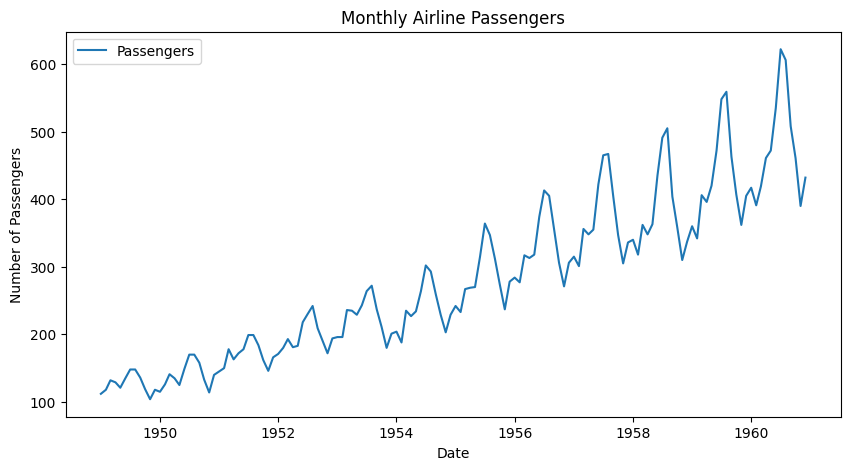

In [11]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Passengers'], label='Passengers')
plt.title('Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [12]:
# Step 2: Preprocess the data
# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(df.values)

In [13]:
# Create sequences for time series forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # Use the past 12 months to predict the next month
X, y = create_sequences(data, seq_length)

In [14]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [32]:
# Step 3: Build the Transformer model
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, output_dim, dropout_rate=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_seq_len = input_seq_len
        self.output_dim = output_dim

        # Positional Encoding
        self.pos_encoding = self.positional_encoding(input_seq_len, d_model)

        # Encoder layers
        self.encoder_layers = [
            self.encoder_layer(d_model, num_heads, dff, dropout_rate)
            for _ in range(num_layers)
        ]

        # Final dense layer
        self.final_layer = tf.keras.layers.Dense(output_dim)

    def positional_encoding(self, seq_len, d_model):
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def encoder_layer(self, d_model, num_heads, dff, dropout_rate):
        # Return a list of layers instead of a Sequential model
        return [
            # Multi-head attention
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.LayerNormalization(epsilon=1e-6),

            # Feed-forward network
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
        ]

    def call(self, x, training):
        seq_len = tf.shape(x)[1]

        # Add positional encoding
        x += self.pos_encoding[:, :seq_len, :]

        # Pass through encoder layers
        for layer in self.encoder_layers:
            # Apply multi-head attention
            attention_output = layer[0](query=x, value=x, training=training)
            x = attention_output + x  # Residual connection
            x = layer[1](x)  # Dropout
            x = layer[2](x)  # LayerNorm

            # Feed-forward network
            ffn_output = layer[3](x)
            ffn_output = layer[4](ffn_output)
            x = ffn_output + x  # Residual connection
            x = layer[5](x)  # Dropout
            x = layer[6](x)  # LayerNorm

        # Final dense layer
        x = self.final_layer(x[:, -1, :])  # Use only the last time step for prediction
        return x

In [33]:
# Hyperparameters
num_layers = 2
d_model = 64
num_heads = 4
dff = 128
dropout_rate = 0.1
input_seq_len = seq_length
output_dim = 1

In [34]:
# Instantiate the model
model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_seq_len, output_dim, dropout_rate)

In [36]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error
)

In [37]:
# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 2.4946 - mae: 1.3362 - val_loss: 0.4184 - val_mae: 0.4659
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3949 - mae: 0.9606 - val_loss: 0.3239 - val_mae: 0.4578
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4760 - mae: 0.5492 - val_loss: 0.4980 - val_mae: 0.6385
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4857 - mae: 0.5623 - val_loss: 0.4492 - val_mae: 0.4774
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3803 - mae: 0.4436 - val_loss: 0.3445 - val_mae: 0.4340
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2340 - mae: 0.3866 - val_loss: 0.3335 - val_mae: 0.4981
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2039 - mae: 0.3684 - val_loss: 0.3645 - val_mae: 0.5362
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2559 - mae: 0.3908 - val_loss: 0.3049 - val_mae: 0.4265
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2129 - mae: 0.3603 -

In [38]:
# Step 5: Evaluate the model
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


In [39]:
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = tf.keras.losses.MeanSquaredError()(y_test_rescaled, y_pred_rescaled).numpy()
mae = tf.keras.losses.MeanAbsoluteError()(y_test_rescaled, y_pred_rescaled).numpy()

In [40]:
print(f"\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


Model Evaluation:
Mean Squared Error (MSE): 1083.101318359375
Mean Absolute Error (MAE): 27.690677642822266


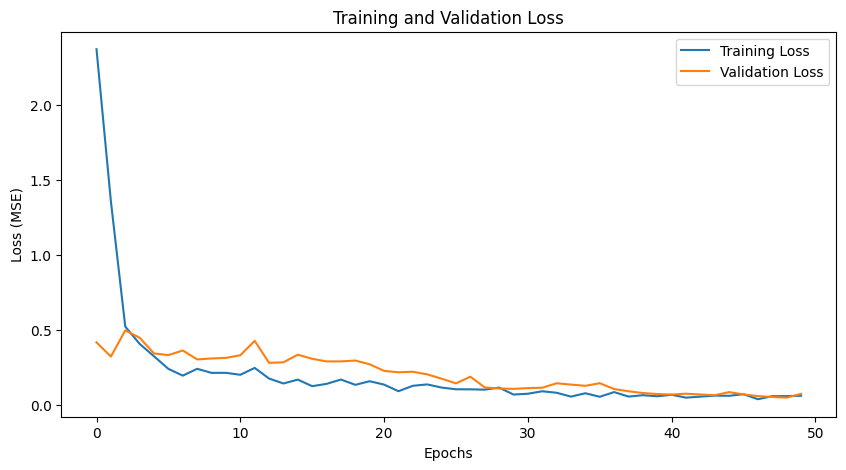

In [41]:
# Step 6: Visualize Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

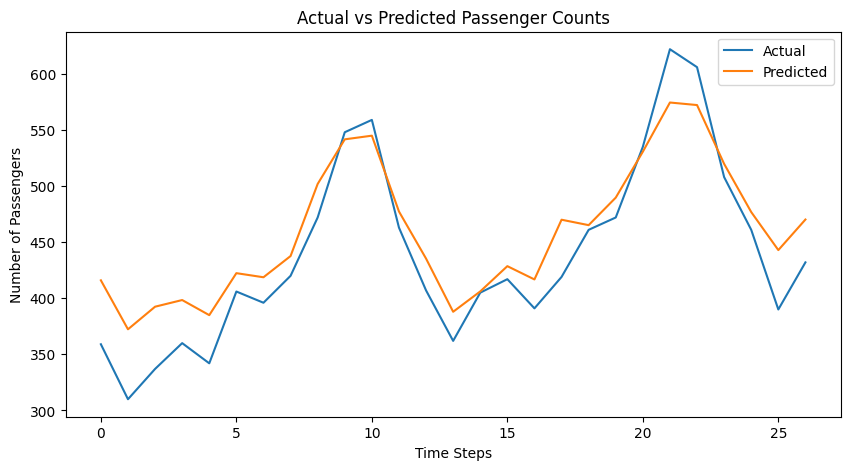

In [42]:
# Step 7: Compare Predictions with Actual Values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted Passenger Counts')
plt.xlabel('Time Steps')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()